In [ ]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
from google.colab import output
solvers.options['show_progress'] = False

In [ ]:
def mean_variance_model_cvxopt(asset_prices, R, S):
  if (S==1):
    ww = np.zeros(len(asset_prices[0]))
    ww[0] = 1
    return 1000000, ww
  temparr = asset_prices[:,:S]
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
  exp_return = np.mean(return_rate,axis=0)
  temp_cov = np.cov(np.transpose(return_rate))
  num_companies = S

  temp_cov += np.eye(num_companies) * 1e-6
  e = np.ones(num_companies)

  P = matrix(2*temp_cov)
  q = matrix(np.zeros(num_companies))

  A = matrix(np.array([e, exp_return]))
  b = matrix(np.array([1,R]))

  G = matrix(-np.eye(num_companies))
  h = matrix(np.zeros(num_companies))
  sol = solvers.qp(P, q, G=G, h=h, A=A, b=b)

  wmw = np.array(sol['x'])
  wmw = wmw/sum(wmw)

  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)

  for _ in range(len(asset_prices[0])-S):
    wmw = np.append(wmw,0)

  return mkw_risk, wmw

In [ ]:
def lowerLevelSolutionArray(ogarr, candidate_returns, candidate_number_of_assets):

  n = len(candidate_returns)
  minRisks = []

  for ind in range(n):
    solInd, ww = mean_variance_model_cvxopt(ogarr,candidate_returns[ind],candidate_number_of_assets[ind])
    minRisks.append(solInd)

  return np.array(minRisks)

In [ ]:
def PSO_Based_Optimisation(asset_prices):
  num_assets = len(asset_prices[0])
  swarm_size = 50

  swarm_returns = np.random.uniform(0, 1, swarm_size) # better upper limit??
  swarm_cardinality = np.random.randint(0.1*num_assets, 0.5*num_assets, swarm_size)

  particle_best_return = np.zeros(swarm_size)
  particle_best_cardinality = np.zeros(swarm_size)
  particle_best_objective = np.zeros(swarm_size)

  for ind in range(swarm_size):
    particle_best_return[ind], particle_best_cardinality[ind] = swarm_returns[ind], swarm_cardinality[ind]

  # bestReturn, bestCardinality, bestPrimary
  min_Risks = lowerLevelSolutionArray(asset_prices, swarm_returns, swarm_cardinality)
  max_primary = -1e12
  best_primary = -1e12
  best_particle_index = 0

  for ind in range(swarm_size):
    particle_best_return[ind], particle_best_cardinality[ind] = swarm_returns[ind], swarm_cardinality[ind]
    particle_objective = swarm_returns[ind]/min_Risks[ind]
    if (particle_objective > max_primary):
      max_primary = particle_objective
      best_particle_index = ind

  best_return = swarm_returns[best_particle_index]
  best_cardinality = swarm_cardinality[best_particle_index]
  best_primary = max_primary

  c1_return = 0.01
  c2_return = 0.01
  c1_cardinality = 0.01
  c2_cardinality = 0.01
  w_return = 0.4
  w_cardinality = 0.4

  improvement = 10
  incLimit = 1e-4
  iterations = 0

  velocity_return = np.random.uniform(-1, 1, swarm_size)
  velocity_cardinality = np.random.uniform(-0.5, 0.5, swarm_size)

  while ((improvement > incLimit or iterations < 10) and iterations < 100):
    for ind in range(swarm_size):
      velocity_return[ind] = w_return*velocity_return[ind] + c1_return*(np.random.uniform(0,1))*(particle_best_return[ind] - swarm_returns[ind]) + c2_return*(np.random.uniform(0,1)*(best_return - swarm_returns[ind]))
      velocity_cardinality[ind] = w_cardinality*velocity_cardinality[ind] + c1_cardinality*(np.random.uniform(0,1))*(particle_best_cardinality[ind] - swarm_cardinality[ind]) + c2_cardinality*(np.random.uniform(0,1)*(best_cardinality - swarm_cardinality[ind]))

      swarm_returns[ind] += velocity_return[ind]
      swarm_cardinality[ind] += velocity_cardinality[ind]

      swarm_cardinality[ind] = int(swarm_cardinality[ind])
      swarm_cardinality[ind] = min(swarm_cardinality[ind], num_assets)
      swarm_cardinality[ind] = max(swarm_cardinality[ind],2)

      swarm_returns[ind] = max(swarm_returns[ind],0)

    min_Risks = lowerLevelSolutionArray(asset_prices, swarm_returns, swarm_cardinality)
    max_primary = -1e12
    best_particle_index = 0

    for ind in range(swarm_size):
      particle_objective = swarm_returns[ind]/min_Risks[ind]

      if (particle_objective > particle_best_objective[ind]):
        particle_best_return[ind] = swarm_returns[ind]
        particle_best_cardinality[ind] = swarm_cardinality[ind]
        particle_best_objective[ind] = particle_objective

      if (particle_objective > max_primary):
        max_primary = particle_objective
        best_particle_index = ind

    improvement = max_primary - best_primary
    if improvement > 0:
      best_primary = max_primary
      best_return = swarm_returns[best_particle_index]
      best_cardinality = swarm_cardinality[best_particle_index]

    iterations += 1

  # print(best_return, best_cardinality, best_primary)

  return best_return, best_cardinality, best_primary

Data Collection

In [ ]:
pricesDF = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')
pricesDF = pricesDF[pricesDF.columns[1:]]

pricesNP = pricesDF.to_numpy()
return_rate = (pricesNP[:-1] - pricesNP[1:])/pricesNP[1:]
exp_return = np.mean(return_rate,axis=0)

sorted_indices = np.argsort(exp_return)
sorted_pricesNP = pricesNP[:, sorted_indices]

In [ ]:
window = 30
num_days = len(pricesDF.index)
num_companies = pricesDF.columns.size
total_rows = num_days - window # Modified(decreased by 1) as we are checking with actual returns

In [ ]:
weights = []

PSO based algorithm

In [ ]:
for i in range(total_rows):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_variance = np.var(temp_return_rate, axis=0)

  # Sort indices by increasing order of variance
  temp_sorted_indices = np.argsort(temp_variance)

  # Reorder columns of prices array by sorted variance
  temp_sorted_price_np = temp_price_np[:, temp_sorted_indices]

  temp_FinR, temp_FinS, temp_FinP = PSO_Based_Optimisation(temp_sorted_price_np)
  temp_riskInvolved, temp_reqWeights = mean_variance_model_cvxopt(temp_sorted_price_np, temp_FinR, temp_FinS)

  # Reorder `temp_reqWeights` to match the original order
  reordered_weights = np.zeros_like(temp_reqWeights)
  reordered_weights[temp_sorted_indices] = temp_reqWeights

  weights.append(reordered_weights)

<ipython-input-2-94af527ef51c>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mkw_risk = math.sqrt(wmw.T@temp_cov@wmw)


In [ ]:
weights_df = pd.DataFrame(weights)
weights_df.to_csv("weights_pso_bilevel.csv", index=False, header=False)

In [ ]:
weights_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.252257,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.076262,0.000000,0.076262,0.076262,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.220185,0.000000
2,0.0,0.0,0.0,0.0,0.149307,0.000000,0.000344,0.001741,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.089601,0.000000,0.056709,0.080617,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.033965,0.000000
4,0.0,0.0,0.0,0.0,0.152858,0.000000,0.082852,0.152858,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.0,0.0,0.0,0.0,0.000000,0.079451,0.039194,0.000000,0.0,0.0,...,0.0,0.0,-0.013399,0.0,0.0,0.0,0.0,0.0,0.000000,0.065604
215,0.0,0.0,0.0,0.0,0.000000,0.095373,0.000002,0.000000,0.0,0.0,...,0.0,0.0,0.508119,0.0,0.0,0.0,0.0,0.0,0.000000,0.000008
216,0.0,0.0,0.0,0.0,0.071743,0.063431,0.069742,0.000000,0.0,0.0,...,0.0,0.0,0.021643,0.0,0.0,0.0,0.0,0.0,0.057115,0.080296
217,0.0,0.0,0.0,0.0,-0.189658,0.000000,0.099138,0.000000,0.0,0.0,...,0.0,0.0,0.099138,0.0,0.0,0.0,0.0,0.0,0.000000,0.099138


Comparison

In [ ]:
weights_ga_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/weights_var_cvxopt.csv')
weights_ga_bilevel = weights_ga_bilevel_df.to_numpy()
weights_ga_bilevel = weights_ga_bilevel[1:]

weights_pso_bilevel_df = pd.read_csv('/content/drive/MyDrive/Weights without transaction cost/BiLevel Solution Weights/weights_pso_bilevel.csv')
weights_pso_bilevel = weights_pso_bilevel_df.to_numpy()
weights_pso_bilevel = weights_pso_bilevel[1:]

In [ ]:
return_at_weights_ga_bilevel = []
return_at_weights_pso_bilevel = []
day = []

In [ ]:
for i in range(num_days-window-2):
  rog = weights_ga_bilevel[i]@return_rate[i] # Because the first row has been removed from weights
  return_at_weights_ga_bilevel.append(rog)

  rvar = weights_pso_bilevel[i]@return_rate[i]
  return_at_weights_pso_bilevel.append(rvar)

  day.append(i+1)

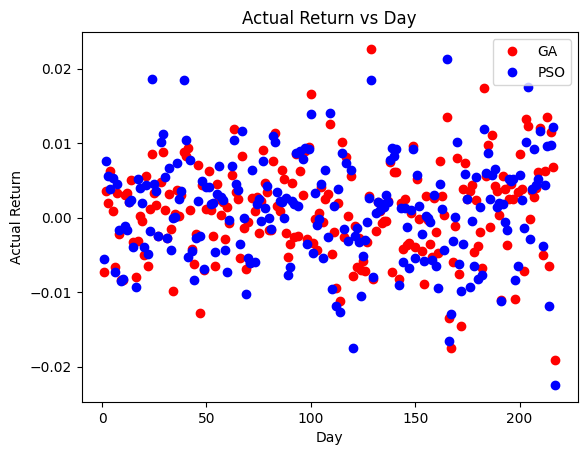

In [ ]:
plt.plot(day,return_at_weights_ga_bilevel,'o',color='r',label='GA')
plt.plot(day,return_at_weights_pso_bilevel,'o',color='b',label='PSO')
plt.xlabel('Day')
plt.ylabel('Actual Return')
plt.title('Actual Return vs Day')
plt.legend()
plt.show()

In [ ]:
print(sum(return_at_weights_pso_bilevel))
print(sum(return_at_weights_ga_bilevel))

0.2287063600416399
0.1844175204409447


In [ ]:
primary_objective_ga = []
primary_objective_pso = []
expected_return_ga = []
expected_return_pso = []
day_primary = []

In [ ]:
for i in range(1,total_rows-1):
  temp_price_df = pricesDF[i:i+window]
  temp_price_np = temp_price_df.to_numpy()

  temp_return_rate = (temp_price_np[:-1] - temp_price_np[1:])/temp_price_np[1:]
  temp_exp_return = np.mean(temp_return_rate,axis=0)

  temp_cov = np.cov(np.transpose(temp_return_rate))

  return_ga = weights_ga_bilevel[i-1]@temp_exp_return
  expected_return_ga.append(return_ga)
  return_pso = weights_pso_bilevel[i-1]@temp_exp_return
  expected_return_pso.append(return_pso)

  risk_ga = math.sqrt(weights_ga_bilevel[i-1].T@temp_cov@weights_ga_bilevel[i-1])
  risk_pso = math.sqrt(weights_pso_bilevel[i-1].T@temp_cov@weights_pso_bilevel[i-1])

  primary_objective_ga.append(return_ga/risk_ga)
  primary_objective_pso.append(return_pso/risk_pso)
  day_primary.append(i-1)

In [ ]:
print(sum(primary_objective_ga))
print(sum(primary_objective_pso))

7.306817369597291
4.929533433310968


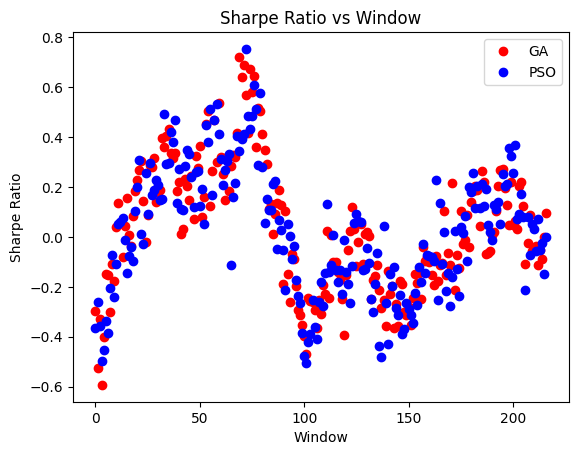

In [ ]:
plt.plot(day_primary,primary_objective_ga,'o',color='r',label='GA')
plt.plot(day_primary,primary_objective_pso,'o',color='b',label='PSO')
plt.xlabel('Window')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Window')
plt.legend()
plt.savefig('SharpeVSWindow.eps', format="eps")
plt.show()

In [ ]:
diff_ga = []
diff_pso = []

for i in range(len(primary_objective_ga)):
  diff_ga.append(abs(expected_return_ga[i]-return_at_weights_ga_bilevel[i]))
  diff_pso.append(abs(expected_return_pso[i]-return_at_weights_pso_bilevel[i]))

In [ ]:
print(sum(diff_ga))
print(sum(diff_pso))

1.113379296696308
1.2317142630028695


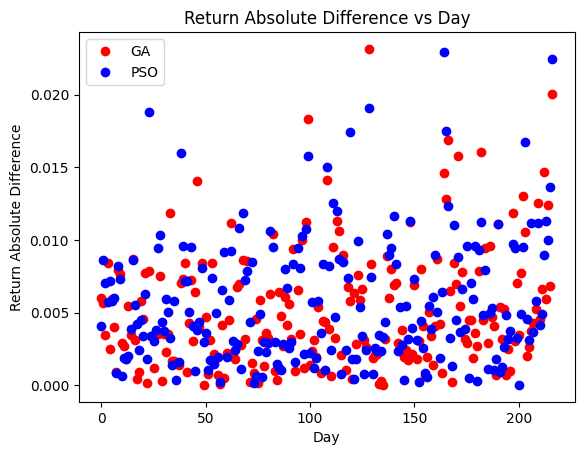

In [ ]:
plt.plot(day_primary,diff_ga,'o',color='r',label='GA')
plt.plot(day_primary,diff_pso,'o',color='b',label='PSO')
plt.xlabel('Day')
plt.ylabel('Return Absolute Difference')
plt.title('Return Absolute Difference vs Day')
plt.legend()
plt.show()